# Unstructured Data Final Project
### Brett Bartol

## Looking at Job Descriptions

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
jobs1 = pd.read_csv('linkedin (3).csv')
jobs2 = pd.read_csv('linkedin2 (4).csv')
jobs = jobs1.append(jobs2)
jobs = jobs[['jobcard-href', 'job_title', 'job_description']]

In [31]:
jobs.head()

,jobcard-href,job_title,job_description
0,https://www.linkedin.com/jobs/view/2702914262/...,Products Data Science Manager,About the job\r\n \r\n\r\n\r\n ...
1,https://www.linkedin.com/jobs/view/2726124988/...,Data Science Engineer - Guaranteed sign on bon...,About the job\r\n \r\n\r\n\r\n ...
2,https://www.linkedin.com/jobs/view/2731017808/...,"Data Science Manager, Ads and Business Products",About the job\r\n \r\n\r\n\r\n ...
3,https://www.linkedin.com/jobs/view/2702918041/...,Products Data Science Manager,About the job\r\n \r\n\r\n\r\n ...
4,https://www.linkedin.com/jobs/view/2738326508/...,Data Science/ Analytics Associate Manager,About the job\r\n \r\n\r\n\r\n ...


In [32]:
def split_clean(text):
    
    text = str(text).lower().split(' ')
    text = [x.replace('\r', '').replace('\n', '') for x in text]
    text = [x for x in text if x != '']
    
    return text

In [33]:
jobs['job_text'] = jobs['job_description'].apply(split_clean)

In [34]:
jobs.head()

,jobcard-href,job_title,job_description,job_text
0,https://www.linkedin.com/jobs/view/2702914262/...,Products Data Science Manager,About the job\r\n \r\n\r\n\r\n ...,"[about, the, job, accenture, is, a, global, pr..."
1,https://www.linkedin.com/jobs/view/2726124988/...,Data Science Engineer - Guaranteed sign on bon...,About the job\r\n \r\n\r\n\r\n ...,"[about, the, job, introductionjoin, asml, wilt..."
2,https://www.linkedin.com/jobs/view/2731017808/...,"Data Science Manager, Ads and Business Products",About the job\r\n \r\n\r\n\r\n ...,"[about, the, job, facebook's, mission, is, to,..."
3,https://www.linkedin.com/jobs/view/2702918041/...,Products Data Science Manager,About the job\r\n \r\n\r\n\r\n ...,"[about, the, job, accenture, is, a, global, pr..."
4,https://www.linkedin.com/jobs/view/2738326508/...,Data Science/ Analytics Associate Manager,About the job\r\n \r\n\r\n\r\n ...,"[about, the, job, we, are:accenture, interacti..."


In [ ]:
all_text = ''
for comment in jobs['job_description']:
    all_text += str(comment).replace('\r', '').replace('\n', '')

#all_text

In [36]:
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english') + list(punctuation) + list(''))

def filter_stop(text):
    text = text.split(' ')
    text = [x.lower() for x in text if x not in stop_words]
    return text

In [37]:
text_out = filter_stop(all_text)
text_out2 = text_out.copy()

In [98]:
word_counts = {}
for word in text_out:
    if word not in stop_words:
        if word in word_counts:
            word_counts[word] = word_counts[word] + 1
        else:
            word_counts[word] = 1
word_counts.pop('')
#word_counts

97451

In [99]:
counts = pd.Series(word_counts).to_frame().reset_index()
counts = counts.rename(columns = {'index' : 'word', 0 : 'count'}).sort_values(by = 'count', ascending = False)

In [100]:
counts.head(10)

,word,count
64,data,19140
344,business,6315
13,experience,6197
144,science,5336
109,work,4574
62,team,4557
0,job,3182
93,analytics,2973
66,machine,2747
163,years,2719


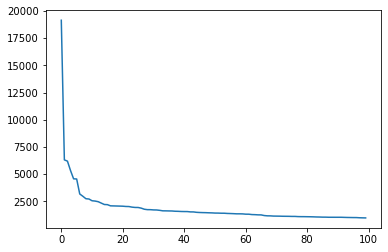

In [101]:
plt.plot(range(100), counts['count'][:100])

## Getting Text from Syllabi

In [107]:
import docx2txt
def doc_text(file):
    doc = docx2txt.process(file)
    return doc.replace('\r', ' ').replace('\n', ' ')

In [108]:
import PyPDF2
def pdf_text(file):
    pdf_file = open(file, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdf_file)
    pdf = ''
    for i in range(pdfReader.numPages):
        pdf += pdfReader.getPage(i).extractText()
    return pdf.replace('\r', ' ').replace('\n', ' ')

In [132]:
AML = doc_text('MIS 382N syllabus f21.docx')
Unstructured = doc_text('Syllabus Analytics for Unstructured Data MSBA Barua F2021-1.docx')
Optimization = doc_text('Syllabus_F21.docx')
Database = pdf_text('381N Syllabus - MW version.pdf')

syllabi = [('Advanced Machine Learning', AML), ('Analytics for Unstructured Data', Unstructured), ('Optimization I', Optimization), ('Intro to Database Management', Database)]

## Comparing Syllabi to Job Descriptions

In [185]:
import math
from statistics import mean
def doc_similarity(query, word_lists):
    #query = split_clean(query)
    tf_idf = np.zeros((len(query), len(word_lists)))
    for i, word in enumerate(query):
        for j, doc in enumerate(word_lists):
            if word in doc:
                tf_idf[i, j] = 1
    
    idf = np.zeros(len(query))
    for i in range(len(idf)):
        if sum(tf_idf[i, :]) == 0:
            idf[i] = 0
        else:
            idf[i] = math.log10(sum(tf_idf[i, :]) / tf_idf.shape[1])
        
        tf_idf[i, :] *= idf[i]
        
    similarities = np.zeros(tf_idf.shape[1])
    for i in range(len(similarities)):
        similarities[i] = (tf_idf[:, i] @ idf) / ((sum(tf_idf[:, i] ** 2)) * (sum(idf ** 2)) ** .5)
        
    return mean(similarities)

In [186]:
results = []
for title, text in syllabi:
    doc_sim = doc_similarity(split_clean(text), jobs['job_text'])
    result = title + ' Average Similarity: ' + str(doc_sim)
    results.append(doc_sim)
    print(result)

Advanced Machine Learning Average Similarity: 0.0243501130306093
Analytics for Unstructured Data Average Similarity: 0.02499437985477472
Optimization I Average Similarity: 0.01594431446285424
Intro to Database Management Average Similarity: 0.014826703695169686


In [187]:
df = pd.DataFrame(syllabi, columns = ['title', 'text'])
df['cosine'] = results        

Text(0, 0.5, 'Cosine Similarity')

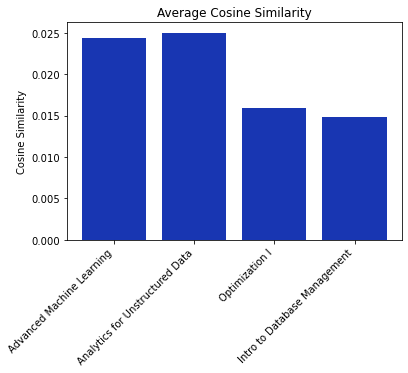

In [195]:
plt.bar(df['title'], df['cosine'], color = '#1836b2')
plt.xticks(rotation = 45, ha = 'right')
plt.title('Average Cosine Similarity')
plt.ylabel('Cosine Similarity')

In [189]:
## Creating Bi-grams and Tri-grams
def make_bigram_etc(text, group_size):
    bigram_list = []
    text = split_clean(text)
    for i in range(len(text) - group_size + 1):
        gram = []
        for j in range(group_size):
               gram.append(text[i + j].replace('\r', '').replace('\n', '')) 
        gram = ' '.join(gram)
        bigram_list.append(gram)
    
    return bigram_list

In [190]:
make_bigram_etc(AML, 3)[:10]

['mis 382n: advanced',
 '382n: advanced machine',
 'advanced machine learning',
 'machine learning course',
 'learning course syllabus',
 'course syllabus instuctor:',
 'syllabus instuctor: prof.',
 'instuctor: prof. joydeep',
 'prof. joydeep ghosh,',
 'joydeep ghosh, jghosh@utexas.edu']

In [191]:
make_bigram_etc(AML, 2)[:10]

['mis 382n:',
 '382n: advanced',
 'advanced machine',
 'machine learning',
 'learning course',
 'course syllabus',
 'syllabus instuctor:',
 'instuctor: prof.',
 'prof. joydeep',
 'joydeep ghosh,']

In [192]:
jobs['bigram'] = jobs['job_description'].apply(lambda x : make_bigram_etc(x, 2))
jobs['trigram'] = jobs['job_description'].apply(lambda x : make_bigram_etc(x, 3))

In [193]:
jobs[['bigram', 'trigram']].head()

,bigram,trigram
0,"[about the, the job, job accenture, accenture ...","[about the job, the job accenture, job accentu..."
1,"[about the, the job, job introductionjoin, int...","[about the job, the job introductionjoin, job ..."
2,"[about the, the job, job facebook's, facebook'...","[about the job, the job facebook's, job facebo..."
3,"[about the, the job, job accenture, accenture ...","[about the job, the job accenture, job accentu..."
4,"[about the, the job, job we, we are:accenture,...","[about the job, the job we, job we are:accentu..."


In [239]:
# for title, text in syllabi:
#     doc_sim = doc_similarity(make_bigram_etc(text, 2), jobs['bigram'])
#     result = title + ' Average Similarity: ' + str(doc_sim)
#     print(result)

In [240]:
# for title, text in syllabi:
#     doc_sim = doc_similarity(make_bigram_etc(text, 3), jobs['trigram'])
#     result = title + ' Average Similarity: ' + str(doc_sim)
#     print(result)

In [241]:
job_types = ['Analyst', 'Manager','Data Science', 'Data Scientist','Data Engineer', 
             'Business Intelligence', 'Intern','Associate']

def change_job_title(title):
    for job in job_types:
        if job in title:
            return job
            break
    return title
            
jobs['job_title'] = jobs['job_title'].apply(change_job_title)

data_scientist = jobs[jobs['job_title'] == "Data Science"].append(jobs[jobs['job_title'] == "Data Scientist"])

data_analyst = jobs[jobs['job_title'] == "Analyst"]

In [242]:
data_scientist.head()

,jobcard-href,job_title,job_description,job_text,bigram,trigram
1,https://www.linkedin.com/jobs/view/2726124988/...,Data Science,About the job\r\n \r\n\r\n\r\n ...,"[about, the, job, introductionjoin, asml, wilt...","[about the, the job, job introductionjoin, int...","[about the job, the job introductionjoin, job ..."
5,https://www.linkedin.com/jobs/view/2724547997/...,Data Science,About the job\r\n \r\n\r\n\r\n ...,"[about, the, job, what, makes, gartner, resear...","[about the, the job, job what, what makes, mak...","[about the job, the job what, job what makes, ..."
6,https://www.linkedin.com/jobs/view/2731444424/...,Data Science,About the job\r\n \r\n\r\n\r\n ...,"[about, the, job, what, we'll, bringat, transu...","[about the, the job, job what, what we'll, we'...","[about the job, the job what, job what we'll, ..."
7,https://www.linkedin.com/jobs/view/2738133749/...,Data Science,About the job\r\n \r\n\r\n\r\n ...,"[about, the, job, to, get, the, best, candidat...","[about the, the job, job to, to get, get the, ...","[about the job, the job to, job to get, to get..."
10,https://www.linkedin.com/jobs/view/2732484484/...,Data Science,About the job\r\n \r\n\r\n\r\n ...,"[about, the, job, introductionasml, us, brings...","[about the, the job, job introductionasml, int...","[about the job, the job introductionasml, job ..."


In [243]:
ds_result = []
for title, text in syllabi:
    doc_sim = doc_similarity(split_clean(text), data_scientist['job_text'])
    result = title + ' Average Similarity: ' + str(doc_sim)
    ds_result.append(doc_sim)
    print(result)

KeyboardInterrupt: 

In [ ]:
da_result = []
for title, text in syllabi:
    doc_sim = doc_similarity(split_clean(text), data_analyst['job_text'])
    result = title + ' Average Similarity: ' + str(doc_sim)
    da_result.append(doc_sim)
    print(result)

In [ ]:
df_ds = pd.DataFrame(syllabi, columns = ['title', 'text'])
df_ds['cosine'] = ds_result  
df_da = pd.DataFrame(syllabi, columns = ['title', 'text'])
df_da['cosine'] = da_result  

In [ ]:
df_both = df_ds.merge(df_da, on = 'title', suffixes = ['_ds', '_da'])
df_both

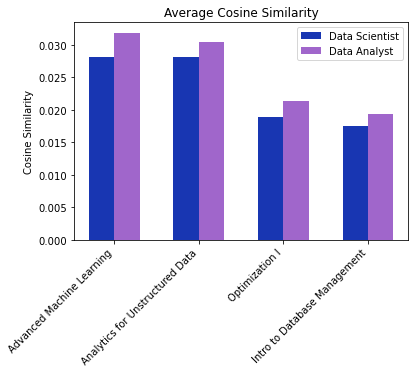

In [244]:
gridnumber = range(1,5)

width = 0.3

plt.bar(np.arange(4), df_both['cosine_ds'], width = width,
                label="Data Scientist", align="center", color = '#1836b2')

plt.bar(np.arange(4) + width, df_both['cosine_da'], width = width,
                label="Data Analyst", align="center", color = '#A066CB')

plt.xticks(np.arange(4) + width / 2, labels = df_both['title'], rotation = 45, ha = 'right')
plt.legend()
plt.title('Average Cosine Similarity')
plt.ylabel('Cosine Similarity')
plt.show()

In [253]:
mkt = doc_text('MKTAnalytics I_MSBA_Fall2021_Syllabus.docx')
sc = pdf_text('2021 Fall OM 380 17 Syllabus - (Aug 22 2021)-1.pdf')
fin = doc_text('BA 385T.docx')

In [254]:
classes = [('Marketing Analytics', mkt), ('Supply Chain Analytics', sc), ('Financial Management', fin)]

In [255]:
elective_result = []
for title, text in classes:
    doc_sim = doc_similarity(split_clean(text), jobs['job_text'])
    result = title + ' Average Similarity: ' + str(doc_sim)
    elective_result.append(doc_sim)
    print(result)

Marketing Analytics Average Similarity: 0.01656438486557023
Supply Chain Analytics Average Similarity: 0.011523910968831168
Financial Management Average Similarity: 0.015407476170633145


In [257]:
df1 = pd.DataFrame(classes, columns = ['title', 'text'])
df1['cosine'] = elective_result 

Text(0, 0.5, 'Cosine Similarity')

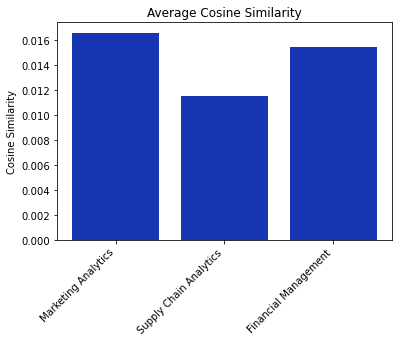

In [258]:
plt.bar(df1['title'], df1['cosine'], color = '#1836b2')
plt.xticks(rotation = 45, ha = 'right')
plt.title('Average Cosine Similarity')
plt.ylabel('Cosine Similarity')